# Period detection in V and I bands


In this notebook I:
1. Make a stacked absolute value image to find variable sources
2. Use the aligned and subtracted images to measure changes in the flux on the detected variable sources
3. Make an score periodograms to find the periods and decide which detected sources are periodic (and have periods short enough for us to detect in this data)

In [191]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table, Column, join
import astropy.units as u
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks

from ccdproc import CCDData, Combiner, subtract_overscan, trim_image, create_deviation

from photutils import DAOStarFinder, CircularAperture, aperture_photometry

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Getting the list of files and seperating by waveband

In [4]:
sub_img_fles = glob("../data/NGC1866_images/*sub.fits")

In [5]:
sub_img_by_band = dict()

for fle in sub_img_fles:
    band = fits.getheader(fle)['FILTER']
    if not sub_img_by_band.get(band):
        sub_img_by_band[band] = [fle]
    sub_img_by_band[band].append(fle)

In [6]:
v_sub_fles = sub_img_by_band["V"]
#i_sub_fles = sub_img_by_band["I"]

In [52]:
i_sub_fles = glob("../data/NGC1866_images/*sub_new.fits")

## Stacking Images

On separate subtracted images, a star may be above or below the background
(which is zero).  Stacking these may add positive and negative fluxes, possibly
yielding something close to zero. Not very advantageous. The trick is to
transform each image so that every pixel is positive. Thus we take the absolute value
of the images before stacking. This will increase the detection ability, genuine
variable stars should stand out better.

Based on going through the images by eye looking for "good" subtraced images (as little "graininess" in the center of the cluster as possible, good FWHM, bright stars leaving as little residuals as possible) I am using the following images:
- V-band: 0,1,22,26
- I-band: 3,6,12,21

#### V-band

In [8]:
v_ccd_dataframes = [CCDData(np.abs(fits.getdata(v_sub_fles[x])), unit=u.dimensionless_unscaled) for x in [0,1,22,26]]
v_combiner = Combiner(v_ccd_dataframes)
v_combiner.data_arr.mask[np.isnan(v_combiner.data_arr)]=True
v_combined_average = v_combiner.average_combine()

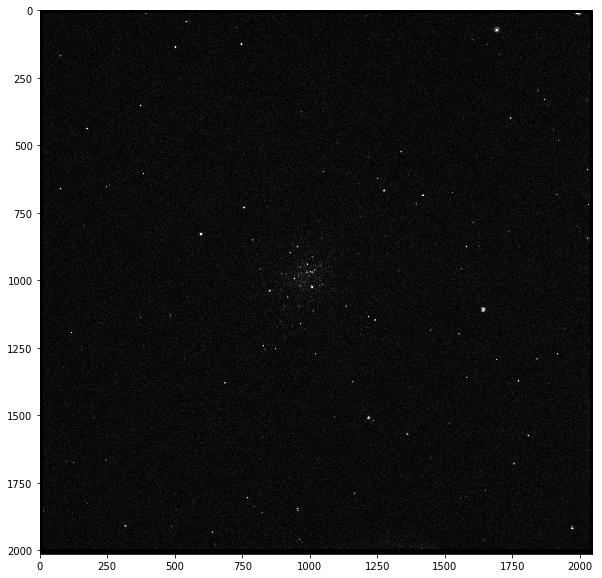

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(v_combined_average.data, cmap='gray',vmin=0,vmax=12)

#### I-band

In [50]:
def display_subtracted_img(fle):
    img = fits.getdata(fle)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    norm = LogNorm(vmin=10,vmax=3000)
    ax.imshow(img, cmap='gray',vmin=0,vmax=40)#, norm=norm)

In [82]:
i_ccd_dataframes = [CCDData(np.abs(fits.getdata(i_sub_fles[x])), unit=u.dimensionless_unscaled) for x in [2,5,10,21]]
i_combiner = Combiner(i_ccd_dataframes)
i_combiner.data_arr.mask[np.isnan(i_combiner.data_arr)]=True
i_combined_average = i_combiner.average_combine()

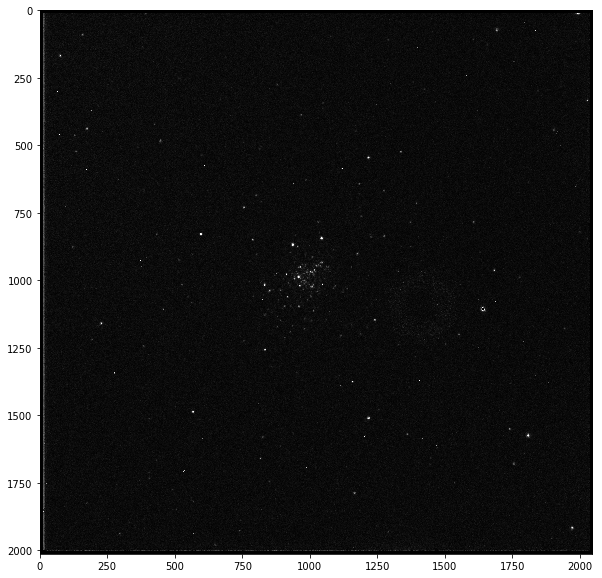

In [84]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(i_combined_average.data, cmap='gray',vmin=0,vmax=30)

## Finding sources in each image

I will use Daofind to make a catalog of sources for each image. At this stage I do not cross correlate with a lis of actual stars, but potentially I will want to cross correlate with both bands and the template to get a canoncial catalog.

Using ds9 and imexamin I determined that I should use a FWHM of 5 for the source detection.

#### V-band

In [85]:
v_img_mean, v_img_median, v_img_std = sigma_clipped_stats(v_combined_average.data, sigma=3.0, maxiters=5)

In [86]:
v_daofind = DAOStarFinder(fwhm=5, threshold=15*v_img_std)
v_img_catalog = v_daofind(v_combined_average.data - v_img_median)
print(len(v_img_catalog))

146


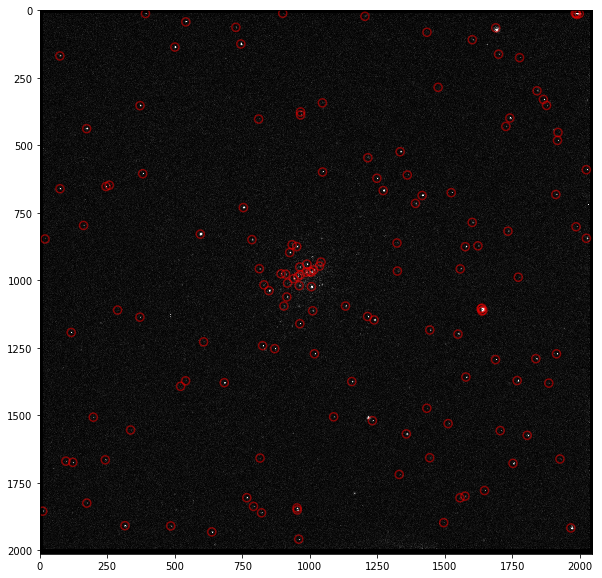

In [97]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(v_combined_average.data, cmap='gray',vmin=0,vmax=10)

positions = (v_img_catalog['xcentroid'], v_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='red', lw=1.5, alpha=0.5)

plt.savefig("../doc/plots/stacked_img_with_detections_v.pdf")

#### I-band

In [107]:
i_img_mean, i_img_median, i_img_std = sigma_clipped_stats(i_combined_average.data, sigma=3.0, maxiters=5)

In [108]:
i_daofind = DAOStarFinder(fwhm=5, threshold=25*i_img_std)
i_img_catalog = i_daofind(i_combined_average.data - i_img_median)
print(len(i_img_catalog))

123


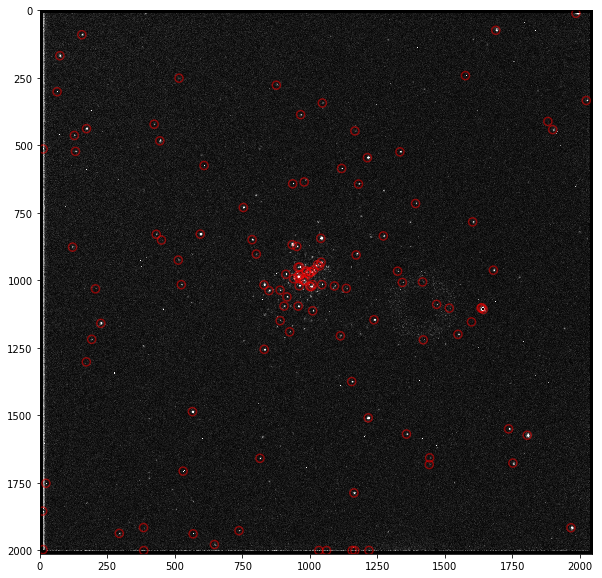

In [109]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(i_combined_average.data, cmap='gray',vmin=0,vmax=15)

positions = (i_img_catalog['xcentroid'], i_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='red', lw=1.5, alpha=0.5)

plt.savefig("../doc/plots/stacked_img_with_detections_i.pdf")

#### Getting "canonical" sources from the v-template image

In [102]:
v_template_img = fits.getdata("../data/NGC1866_images/v_mean_template_crr.fits")

In [110]:
t_img_mean, t_img_median, t_img_std = sigma_clipped_stats(v_template_img, sigma=3.0, maxiters=5)

In [111]:
t_daofind = DAOStarFinder(fwhm=5, threshold=15*t_img_std)
t_img_catalog = t_daofind(v_template_img - t_img_median)
print(len(t_img_catalog))

1360


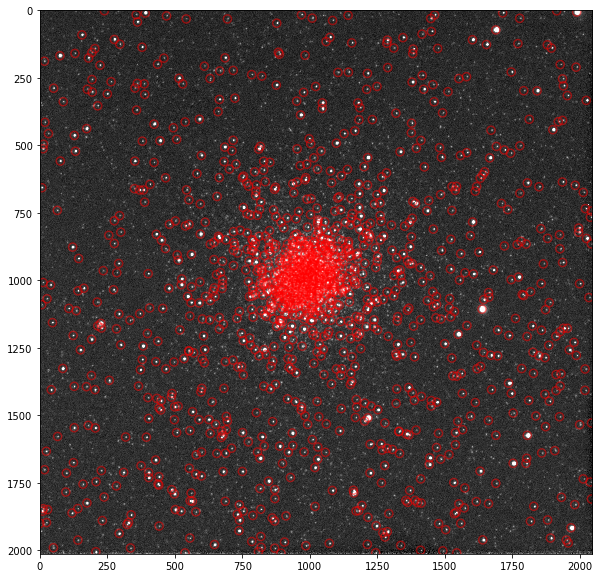

In [112]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(v_template_img, cmap='gray',vmin=0,vmax=15)

positions = (t_img_catalog['xcentroid'], t_img_catalog['ycentroid'])
apertures = CircularAperture(positions, r=15.)
apertures.plot(color='red', lw=1.5, alpha=0.5)

Plotting all the images together, the white stars are variables as they appear in the i and v diff images and the template. The green come from the template.

In [116]:
rgb = np.dstack((i_combined_average.data/10,v_template_img/100,v_combined_average.data/10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


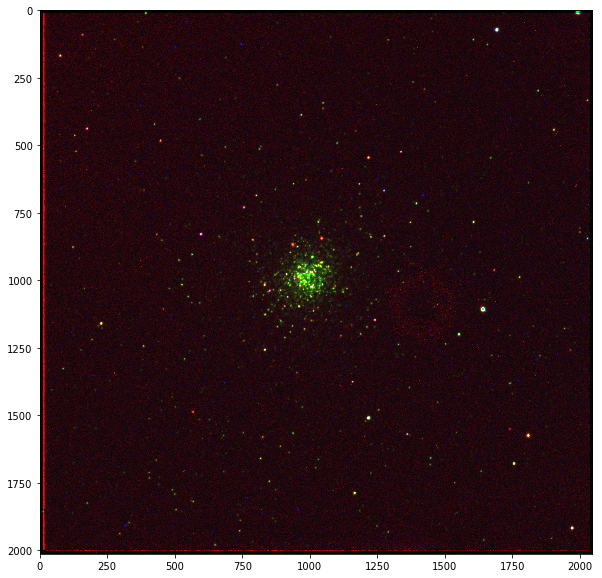

In [117]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(rgb)

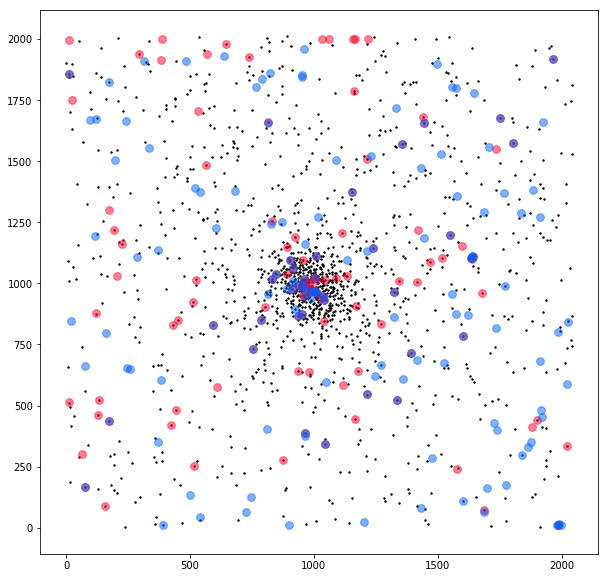

In [132]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(t_img_catalog['xcentroid'], t_img_catalog['ycentroid'],
           linestyle='None',marker='o',s=2,color='black')

ax.scatter(i_img_catalog['xcentroid'], i_img_catalog['ycentroid'],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#ff002b')

ax.scatter(v_img_catalog['xcentroid'], v_img_catalog['ycentroid'],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#0061ff')
plt.show()

The purple splots with the black dots in the middle should be the true variables.

### Catalog matching

We'll need the template catalog, which will have far more stars, since it doesn't just include the variables. We will use the v_template for this, but we could use either.

In [223]:
v_wcs = WCS("../data/NGC1866_images/v_mean_template_crr.fits")
ras,decs = v_wcs.all_pix2world(t_img_catalog['xcentroid'],t_img_catalog['ycentroid'],0)
t_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')
print(f"Number of stars in the template catalog: {len(t_img_catalog)}")

Number of stars in the template catalog: 1360


#### V band
Getting the catalog and performing the crossmatch

In [224]:
ras,decs = v_wcs.all_pix2world(v_img_catalog['xcentroid'],v_img_catalog['ycentroid'],0)
v_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')

In [225]:
idx_v, d2d_v, d3d_v = v_img_catalog['coord'].match_to_catalog_sky(t_img_catalog['coord'])

In [226]:
v_crossmatch_table = Table(names=["x_v","y_v","t_id","v_dist"],
                           data=[v_img_catalog['xcentroid'].data, v_img_catalog['ycentroid'].data, idx_v, d2d_v])

In [227]:
mask = np.array([False]*len(v_crossmatch_table))

for t_id in np.unique(v_crossmatch_table['t_id']):
    if sum(v_crossmatch_table['t_id']==t_id) == 1:
        continue
    mask += ((v_crossmatch_table['t_id']==t_id) & 
             (v_crossmatch_table['v_dist'] != v_crossmatch_table[v_crossmatch_table['t_id']==t_id]['v_dist'].min()))

In [228]:
v_crossmatch_table = v_crossmatch_table[~mask]

#### I band
Getting the catalog and performing the crossmatch

In [229]:
i_wcs = WCS("../data/NGC1866_images/i_mean_template_crr.fits")
ras,decs = v_wcs.all_pix2world(i_img_catalog['xcentroid'],i_img_catalog['ycentroid'],0)
i_img_catalog["coord"]=SkyCoord(ras,decs,unit='deg')

In [230]:
idx_i, d2d_i, d3d_i = i_img_catalog['coord'].match_to_catalog_sky(t_img_catalog['coord'])

In [231]:
i_crossmatch_table = Table(names=["x_i","y_i","t_id","i_dist"],
                           data=[i_img_catalog['xcentroid'].data, i_img_catalog['ycentroid'].data, idx_i, d2d_i])

In [232]:
mask = np.array([False]*len(i_crossmatch_table))

for t_id in np.unique(i_crossmatch_table['t_id']):
    if sum(i_crossmatch_table['t_id']==t_id) == 1:
        continue
    mask += ((i_crossmatch_table['t_id']==t_id) & 
             (i_crossmatch_table['i_dist'] != i_crossmatch_table[i_crossmatch_table['t_id']==t_id]['i_dist'].min()))

In [233]:
i_crossmatch_table = i_crossmatch_table[~mask]

#### Putting together the full crossmatch table

In [234]:
full_crossmatch_table = join(v_crossmatch_table,i_crossmatch_table,"t_id")

In [238]:
full_crossmatch_table.add_column(Column(name="x_t",data=t_img_catalog['xcentroid'][full_crossmatch_table['t_id']]))
full_crossmatch_table.add_column(Column(name="y_t",data=t_img_catalog['ycentroid'][full_crossmatch_table['t_id']]))

Plotting the sources and removing the ones that are still bad.

In [262]:
mask = (full_crossmatch_table['v_dist'] < .0005) & (full_crossmatch_table['i_dist'] < .0005)

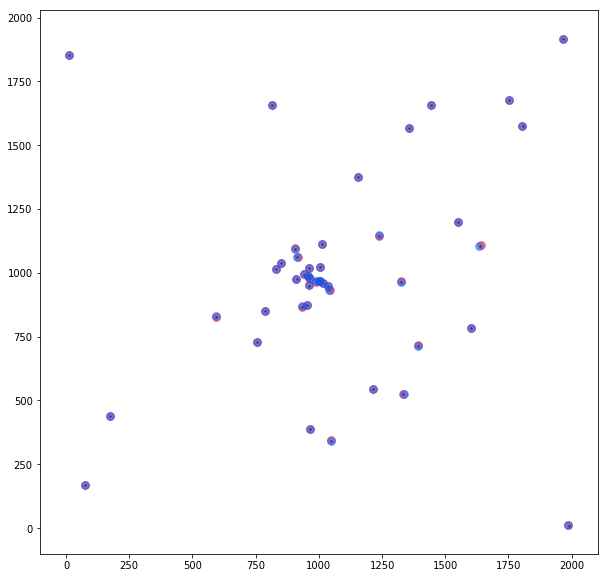

In [263]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(full_crossmatch_table['x_t'][mask], full_crossmatch_table['y_t'][mask],
           linestyle='None',marker='o',s=2,color='black')

ax.scatter(full_crossmatch_table['x_i'][mask], full_crossmatch_table['y_i'][mask],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#ff002b')

ax.scatter(full_crossmatch_table['x_v'][mask], full_crossmatch_table['y_v'][mask],
           linestyle='None',marker='o',alpha=0.5,s=60,color='#0061ff')
plt.show()

In [264]:
full_crossmatch_table = full_crossmatch_table[mask]

In [265]:
print(f"Number of sources in both the I and V band difference images and the template image: {len(full_crossmatch_table)}")

Number of sources in both the I and V band difference images and the template image: 44


#### Plotting the sources on the template image

In [266]:
template_img = fits.getdata("../data/NGC1866_images/v_mean_template.fits")

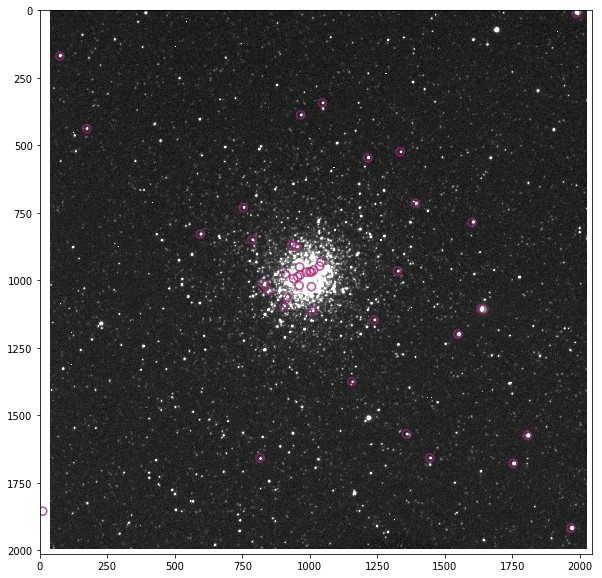

In [268]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#norm = LogNorm(vmin=0,vmax=80)
ax.imshow(template_img.data, cmap='gray',vmin=0,vmax=20)#, norm=norm)

positions_v = (full_crossmatch_table['x_v'], full_crossmatch_table['y_v'])
apertures_v = CircularAperture(positions_v, r=15.)
apertures_v.plot(color='#0061ff', lw=1.5, alpha=0.5)

positions_i = (full_crossmatch_table['x_i'], full_crossmatch_table['y_i'])
apertures_i = CircularAperture(positions_v, r=15.)
apertures_i.plot(color='#ff002b', lw=1.5, alpha=0.5)

plt.savefig("../doc/plots/templat_with_detections.pdf")

Looking good!

### Photometry

Now we perform the photometry.

To better keep track of all the stars, adding an id column to the catalog.

In [286]:
full_crossmatch_table.add_column(Column(name="id",data=list(range(1,len(full_crossmatch_table)+1))))

In [289]:
full_crossmatch_table

<Table length=44>
     x_v           y_v       t_id ...      x_t           y_t        id 
                                  ...                                  
   float64       float64    int64 ...    float64       float64    int64
------------- ------------- ----- ... ------------- ------------- -----
1986.69947065 11.1529546866     2 ... 1988.47429971 6.35959831921     1
74.5604770141 168.923755574    46 ... 74.8878245965 168.156623186     2
1046.72827071 342.790871593   101 ... 1046.50791328 342.788124191     3
966.028998382 387.359907367   110 ...  965.89357669 387.458229279     4
173.854427038 438.201722953   122 ... 173.823722555 438.043554469     5
1334.77001855 523.690935759   152 ... 1334.50919804 523.848639789     6
1215.01198369  545.81385522   158 ... 1214.65863107 545.411361938     7
1391.48723493 714.977270673   238 ... 1391.53488715 715.078909748     8
754.110043312 730.473033436   242 ... 754.015835002 730.072583538     9
          ...           ...   ... ...           ...           ...   ...
1238.20387987 1146.27879413   939 ... 1238.00568871 1145.94621673    35
1548.85133118 1199.08178191   982 ... 1549.21613018 1199.34646433    36
1155.79530654 1374.66834423  1083 ... 1155.59692374  1374.7441369    37
1357.60784296 1568.52810516  1182 ... 1357.59942735 1568.81264135    38
1805.31928725 1573.75366808  1186 ... 1805.50128391 1573.69750511    39
1444.17380249 1656.78097135  1219 ... 1444.01073308  1657.0455323    40
815.930355278 1657.97173241  1220 ... 815.607783878 1658.60878948    41
1752.55691132 1677.52745836  1226 ... 1753.03333781 1677.23380473    42
11.0378581555 1854.70402594  1301 ... 10.4999757437  1854.6407479    43
1966.87292101  1916.7357469  1327 ... 1967.24016192 1916.27441142    44

#### V-band

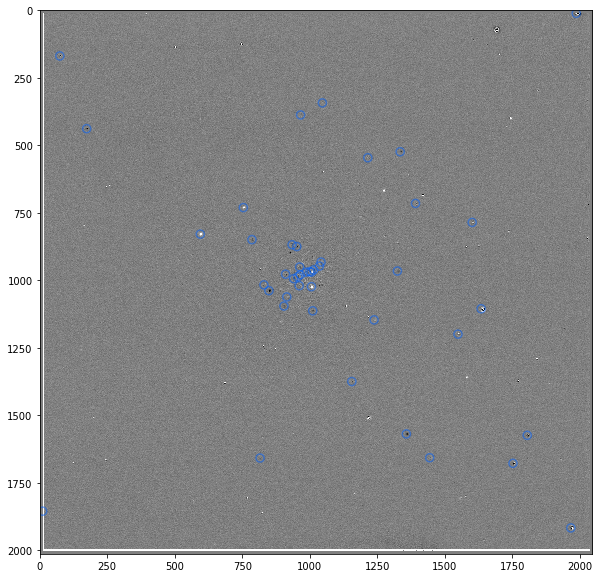

In [276]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

img = fits.getdata(v_sub_fles[0])

ax.imshow(img, cmap='gray',vmin=-10,vmax=10)

positions_v = (full_crossmatch_table['x_v'], full_crossmatch_table['y_v'])
apertures_v = CircularAperture(positions_v, r=15.)
apertures_v.plot(color='#0061ff', lw=1.5, alpha=0.5)

plt.savefig("../doc/plots/subtracted_img_with_detections_v.pdf")

In [293]:
positions_v = [(x['x_v'], x['y_v']) for x in full_crossmatch_table]
apertures_v = CircularAperture(positions_v, r=6)

In [296]:
dates = []
mags = {}
for i in full_crossmatch_table["id"]:
    mags[i]= []
errs = {}
for i in full_crossmatch_table["id"]:
    errs[i]= []

for fle in v_sub_fles:
    
    # Getting what we need from the file
    hdu = fits.open(fle)
    img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    
    dates.append(hdu[0].header["MJD-OBS"])
    
    # Getting the uncertainty
    data = CCDData(np.abs(img), unit=u.adu)
    data_with_deviation = create_deviation(data, gain=header['GAIN'] * u.electron/u.adu,
                                                 readnoise=header['RDNOISE'] * u.electron)
    uncertainty = data_with_deviation.uncertainty.array

    phot_table = aperture_photometry(img, apertures_v, error=uncertainty)
    
    for star in phot_table:
        mags[star['id']].append(star['aperture_sum'])
        errs[star['id']].append(star['aperture_sum_err'])

In [298]:
lc_table_v = Table(names=["filename","date_obs"], data=[v_sub_fles,dates])
for i in full_crossmatch_table["id"]:
    lc_table_v.add_column(Column(name=f"mag_{i}",data=mags[i]))
    lc_table_v.add_column(Column(name=f"mag_err_{i}",data=errs[i]))

In [300]:
for i in full_crossmatch_table["id"]:
    nans = sum(np.isnan(lc_table_v[f'mag_{i}']))
    if nans > 0:
        print(f'{i}: {nans}')

1: 2
43: 15


In [313]:
lc_table_v.sort("date_obs")

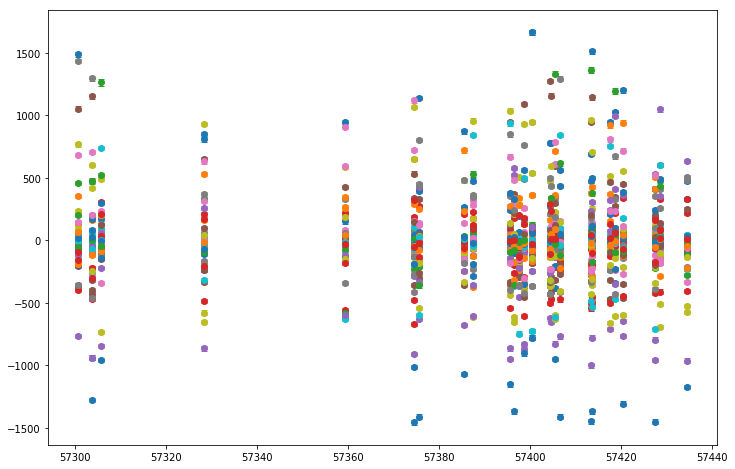

In [302]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for i in full_crossmatch_table['id']:
    ax.errorbar(lc_table_v['date_obs'],lc_table_v[f'mag_{i}'],yerr=lc_table_v[f'mag_err_{i}'],
                marker='o',linestyle='None',capsize=3)
    
#plt.savefig("../doc/plots/all_lcs.pdf")

#### I-band

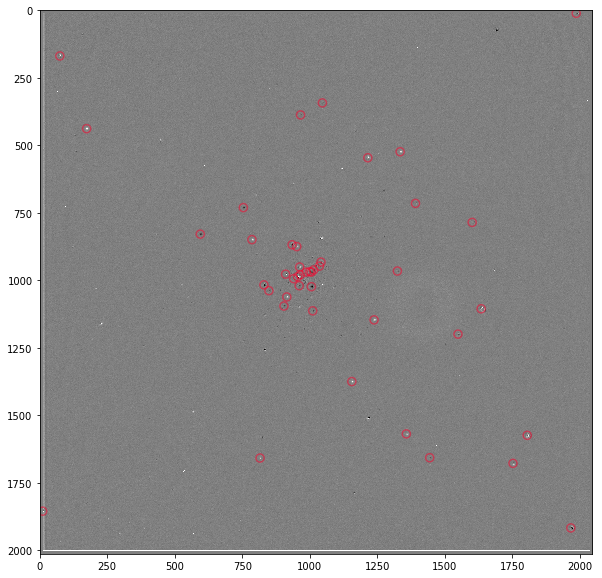

In [306]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

img = fits.getdata(i_sub_fles[2])

ax.imshow(img, cmap='gray',vmin=-40,vmax=40)

positions_i = (full_crossmatch_table['x_i'], full_crossmatch_table['y_i'])
apertures_i = CircularAperture(positions_v, r=15.)
apertures_i.plot(color='#ff002b', lw=1.5, alpha=0.5)

plt.savefig("../doc/plots/subtracted_img_with_detections_i.pdf")

In [307]:
positions_i = [(x['x_i'], x['y_i']) for x in full_crossmatch_table]
apertures_i = CircularAperture(positions_i, r=6)

In [308]:
dates = []
mags = {}
for i in full_crossmatch_table["id"]:
    mags[i]= []
errs = {}
for i in full_crossmatch_table["id"]:
    errs[i]= []

for fle in i_sub_fles:
    
    # Getting what we need from the file
    hdu = fits.open(fle)
    img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    
    dates.append(hdu[0].header["MJD-OBS"])
    
    # Getting the uncertainty
    data = CCDData(np.abs(img), unit=u.adu)
    data_with_deviation = create_deviation(data, gain=header['GAIN'] * u.electron/u.adu,
                                                 readnoise=header['RDNOISE'] * u.electron)
    uncertainty = data_with_deviation.uncertainty.array

    phot_table = aperture_photometry(img, apertures_i, error=uncertainty)
    
    for star in phot_table:
        mags[star['id']].append(star['aperture_sum'])
        errs[star['id']].append(star['aperture_sum_err'])

In [309]:
lc_table_i = Table(names=["filename","date_obs"], data=[i_sub_fles,dates])
for i in full_crossmatch_table["id"]:
    lc_table_i.add_column(Column(name=f"mag_{i}",data=mags[i]))
    lc_table_i.add_column(Column(name=f"mag_err_{i}",data=errs[i]))

In [310]:
for i in full_crossmatch_table["id"]:
    nans = sum(np.isnan(lc_table_i[f'mag_{i}']))
    if nans > 0:
        print(f'{i}: {nans}')

1: 1
43: 11


In [312]:
lc_table_i.sort("date_obs")

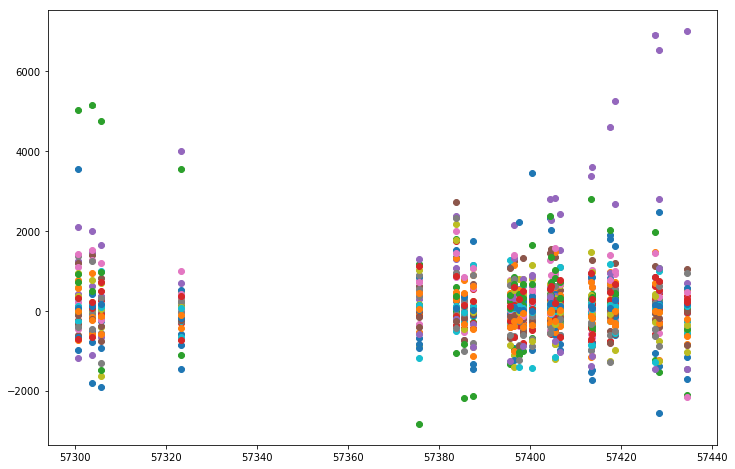

In [314]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for i in full_crossmatch_table['id']:
    ax.errorbar(lc_table_i['date_obs'],lc_table_i[f'mag_{i}'],yerr=lc_table_i[f'mag_err_{i}'],
                marker='o',linestyle='None',capsize=3)
    
#plt.savefig("../doc/plots/all_lcs.pdf")

## Period finding

### The functions we need

In [315]:
def score_period(times, mags, period, hist_size=8, uselog=False, verbose=False):
    """
    Given a period score how good a fit it is.
    Uses the same algorithm as the VARTOOLS Light Curve Analysis Program.  
    """
    
    # initialize the histograms 
    histN = np.zeros(hist_size)
    histA = np.zeros(hist_size)
    histB = np.zeros(hist_size)
    histC = np.zeros(hist_size)
    histD = np.zeros(hist_size)
    histE = np.zeros(hist_size)
    
    for i in range(len(times)):
        if np.isnan(mags[i]):
            continue
            
        X = np.fmod(times[i], period) / period
        index = int(hist_size * X)
        Y = mags[i]
        
        histN[index] += 1
        histA[index] += X
        histB[index] += X * X
        histC[index] += X * Y
        histD[index] += Y
        histE[index] += Y * Y

    sums = 0
    s1 = 0
    L2 = 0
    
    for i in range(hist_size):
        N = histN[i];
        
        if (N <= 1):
            if verbose:
                print("None enough mags in bin.")
            return(100000.0) # Error score, assumed to be bigger than a valid score
        
        Y = histD[i];
        X = Y * Y / N;
        
        # Checking on the denominator
        if ((N*(np.square(histA[i]) - (histB[i]*N)))) == 0:
            #(X + X)^2 - 2*(X^2 + X^2) 
            #print(np.square(histA[i]))
            #print(histB[i]*N)
            #print(histC[i])
            #print(histD[i])
            #print(histE[i])
            #print(histN[i])
            #print()
            continue
        sums += Y
        s1 += X 
        L2 += (np.square((histC[i]*N) - (Y*histA[i])) / (N*(np.square(histA[i]) - (histB[i]*N)))) + histE[i] - X
    
    s1 -= sums * sums / len(times)
    L2 /= len(times) - hist_size
    
    if ((s1 <= 0) or (L2 <= 0)):
        if verbose:
            print("Negative s1 or L2")
        return(100000.0) # Error score, assumed to be bigger than a valid score
    elif(uselog):
        return(np.log(L2 / s1))
    else:
        return(-s1/L2)

In [316]:
def find_best_period(times, mags, errs, clip_sigma=3, peak_height=None, plots=True, outfile=None, verbose=False):
    
    # Getting rid of the nans
    times = times[~np.isnan(mags)]
    errs = errs[~np.isnan(mags)]
    mags = mags[~np.isnan(mags)]
    
    # Getting rid of outliers
    clipped_mags = sigma_clip(mags, sigma=clip_sigma, maxiters=1)
    times = times[~clipped_mags.mask]
    errs = errs[~clipped_mags.mask]
    mags = mags[~clipped_mags.mask]

    # Doing the periodogram
    lomb = LombScargle(times,mags)
    frequency, power = lomb.autopower()
    
    if plots:
        fig = plt.figure(figsize=(10,8))
        ax1 = fig.add_subplot(211)
        ax1.plot(frequency, power)
        ax1.set_xlabel("frequency")
        ax1.set_ylabel("power")
        
    # Finding the peaks 
    peak_inds, _ = find_peaks(power,height=peak_height)
    peak_pds = 1/frequency[peak_inds].value
    
    min_score = 100000
    min_score_pd = 0
    for period in peak_pds:
        score = score_period(times, mags, period, hist_size=5, uselog=True, verbose=False)
        if score < min_score:
            min_score = score
            min_score_pd = period
            
    if verbose:
        print(f"Best score: {min_score}")
        print(f"Best period: {min_score_pd} days")
          
    if plots:
        ax2 = fig.add_subplot(212)
        ax2.errorbar(times%min_score_pd, mags, yerr=errs,
                     marker='o',linestyle='None',capsize=3)
        ax2.set_xlabel("phase (days)")
        ax2.set_ylabel("flux")
        
        if outfile:
            plt.savefig(outfile)
        
        plt.show()  
        
    return min_score_pd, min_score

### Running the period finding

#### V-band

In [317]:
full_crossmatch_table.add_column(Column(name="period_v",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_v",dtype=float,length=len(full_crossmatch_table)))

In [318]:
for star in full_crossmatch_table:
    period,score = find_best_period(lc_table_v['date_obs'], lc_table_v[f'mag_{star["id"]}'], 
                                    lc_table_v[f'mag_err_{star["id"]}'], verbose=False, clip_sigma=2,
                                    plots=False)
    star['period_v'] = period
    star['score_v'] = score

#### I-band

In [324]:
full_crossmatch_table.add_column(Column(name="period_i",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_i",dtype=float,length=len(full_crossmatch_table)))

In [325]:
for star in full_crossmatch_table:
    period,score = find_best_period(lc_table_i['date_obs'], lc_table_i[f'mag_{star["id"]}'], 
                                    lc_table_i[f'mag_err_{star["id"]}'], verbose=False, clip_sigma=2,
                                    plots=False)
    star['period_i'] = period
    star['score_i'] = score

### Comparing the bands and finding good cutoffs

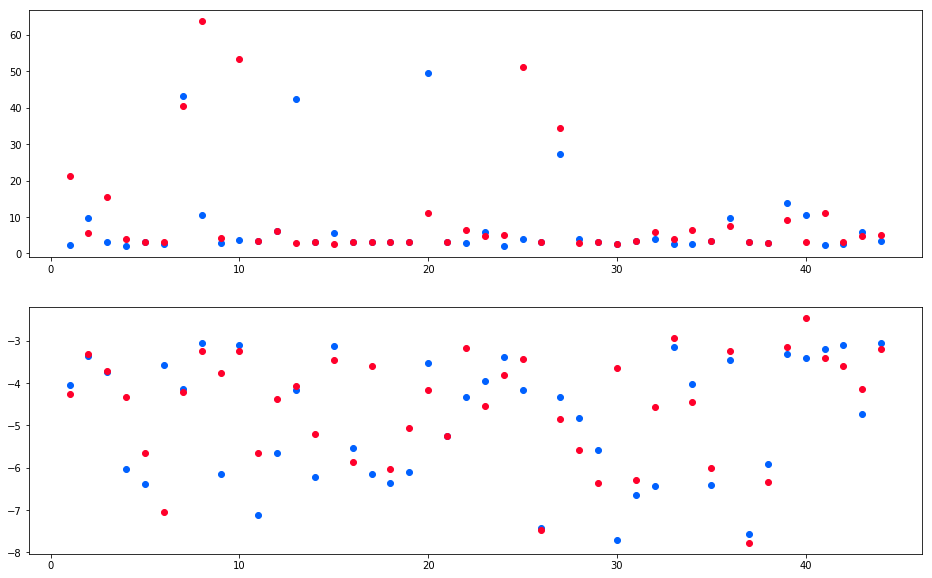

In [337]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
ax1.plot(full_crossmatch_table['id'],full_crossmatch_table['period_v'],'o',color='#0061ff')
ax1.plot(full_crossmatch_table['id'],full_crossmatch_table['period_i'],'o',color='#ff002b')

ax2 = fig.add_subplot(212)
ax2.plot(full_crossmatch_table['id'],full_crossmatch_table['score_v'],'o',color='#0061ff')
ax2.plot(full_crossmatch_table['id'],full_crossmatch_table['score_i'],'o',color='#ff002b')
plt.show()

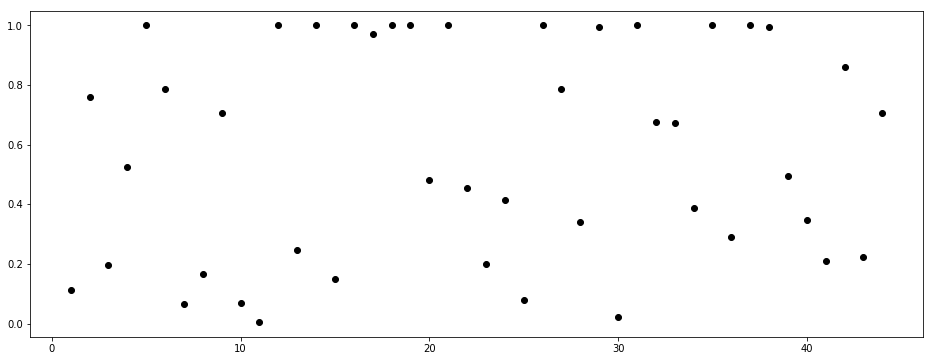

In [347]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111)

ax1.plot(full_crossmatch_table['id'],
         (full_crossmatch_table['period_v']/full_crossmatch_table['period_i'])%1,
         'o',color='black')
#ax1.plot(full_crossmatch_table['id'],full_crossmatch_table['period_i'],'o',color='#ff002b')
plt.show()

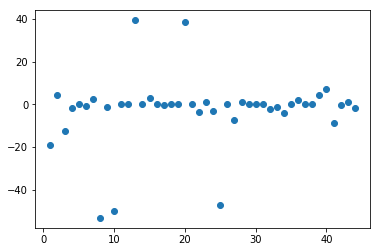

In [351]:
plt.plot(full_crossmatch_table['id'], full_crossmatch_table['period_v']-full_crossmatch_table['period_i'],"o")

In [379]:
def plot_periodic(lc_table_v, lc_table_i, star_row, save=False):
    
    idx = star_row["id"]
    v_pd = star_row["period_v"]
    i_pd = star_row["period_i"]
    
    fig = plt.figure(figsize=(16,8))
    
    ax1 = fig.add_subplot(211)
    ax1.errorbar(lc_table_v['date_obs']%v_pd, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#0061ff', label=f"V band")
    ax1.errorbar(lc_table_i['date_obs']%v_pd, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#ff002b', label=f"I band")
    ax1.set_title(f"V-Band Period: {v_pd:.4}, score: {star_row['score_v']:.4}")
    ax1.set_xlabel("phase (days)")
    ax1.set_ylabel("flux")
    ax1.legend()
    
    ax2 = fig.add_subplot(212, sharex = ax1)
    ax2.errorbar(lc_table_v['date_obs']%i_pd, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#0061ff', label=f"V band")
    ax2.errorbar(lc_table_i['date_obs']%i_pd, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
                marker='o',linestyle='None',capsize=3,color='#ff002b', label=f"I band")
    ax2.set_title(f"I-Band Period: {i_pd:.4}, score: {star_row['score_i']:.4}")
    ax2.set_xlabel("phase (days)")
    ax2.set_ylabel("flux")
    ax2.legend()    

    plt.tight_layout()
        
    if save:
        plt.savefig(f"../doc/plots/phased_lc_{idx}.pdf")
        
    plt.show()  
    

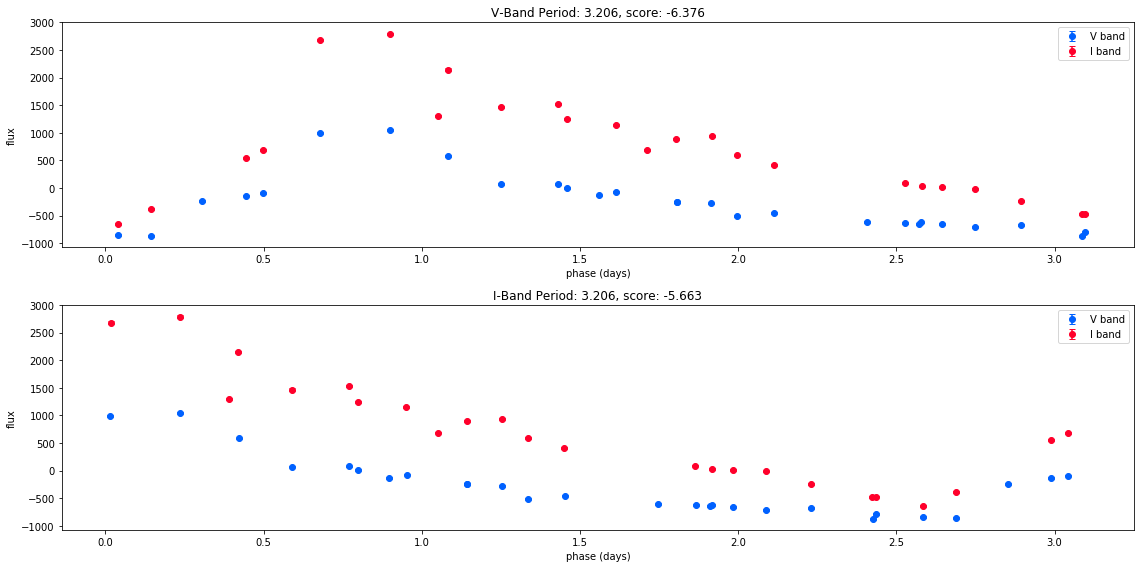

In [443]:
plot_periodic(lc_table_v, lc_table_i, full_crossmatch_table[4])

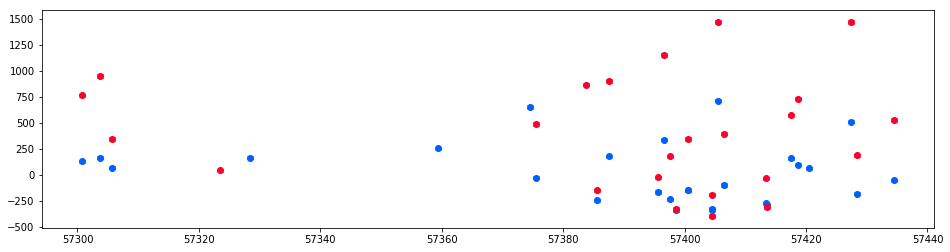

In [396]:
idx = 12
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(111)
ax1.errorbar(lc_table_v['date_obs'], lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
            marker='o',linestyle='None',capsize=3,color='#0061ff', label=f"V band")
ax1.errorbar(lc_table_i['date_obs'], lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
            marker='o',linestyle='None',capsize=3,color='#ff002b', label=f"I band")
plt.show()

In [406]:
full_crossmatch_table.add_column(Column(name="period_best",dtype=float,length=len(full_crossmatch_table)))
full_crossmatch_table.add_column(Column(name="score_best",dtype=float,length=len(full_crossmatch_table)))
for star in full_crossmatch_table:
    if star["score_v"] < star["score_i"]: # V period is better
        star["period_best"] = star["period_v"]
        star["score_best"] = star["score_v"]
    else:
        star["period_best"] = star["period_i"]
        star["score_best"] = star["score_i"]

In [437]:
mask = (full_crossmatch_table["score_best"] < -3.75) & (full_crossmatch_table["period_best"] < 20)
sum(mask)

28

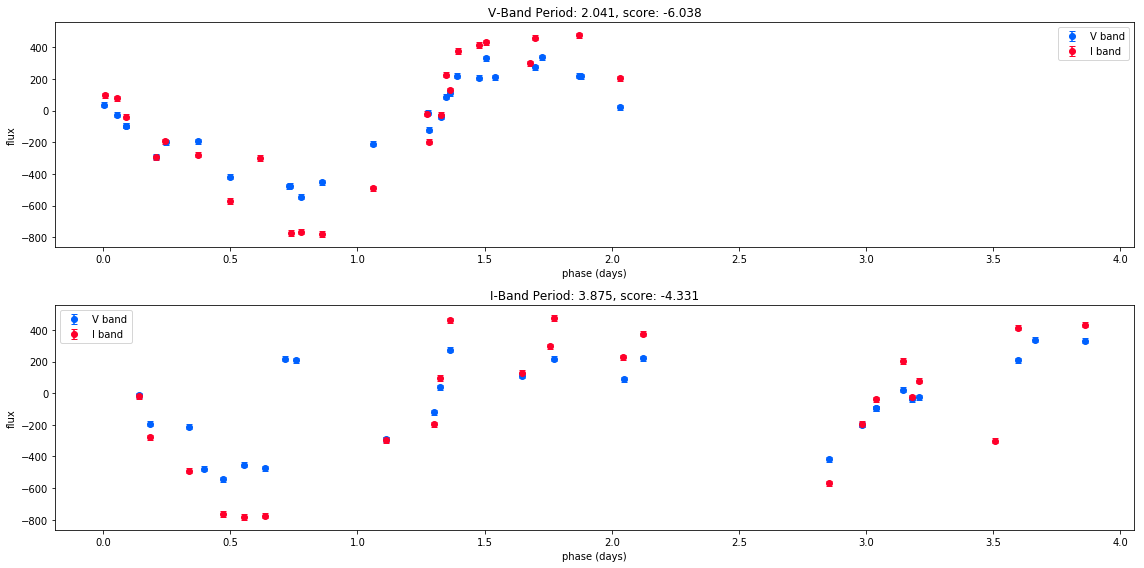

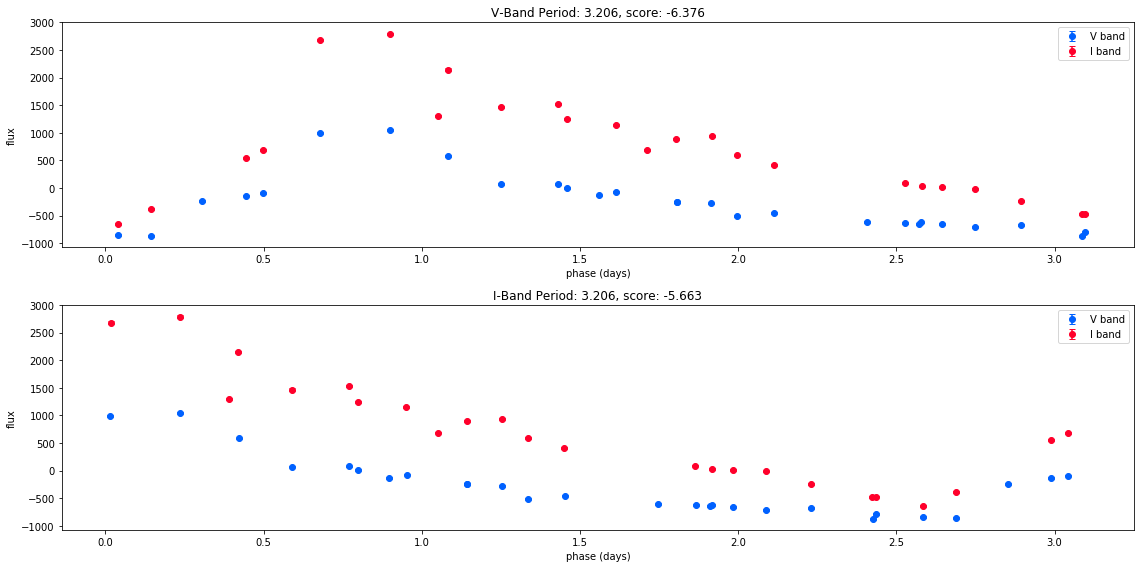

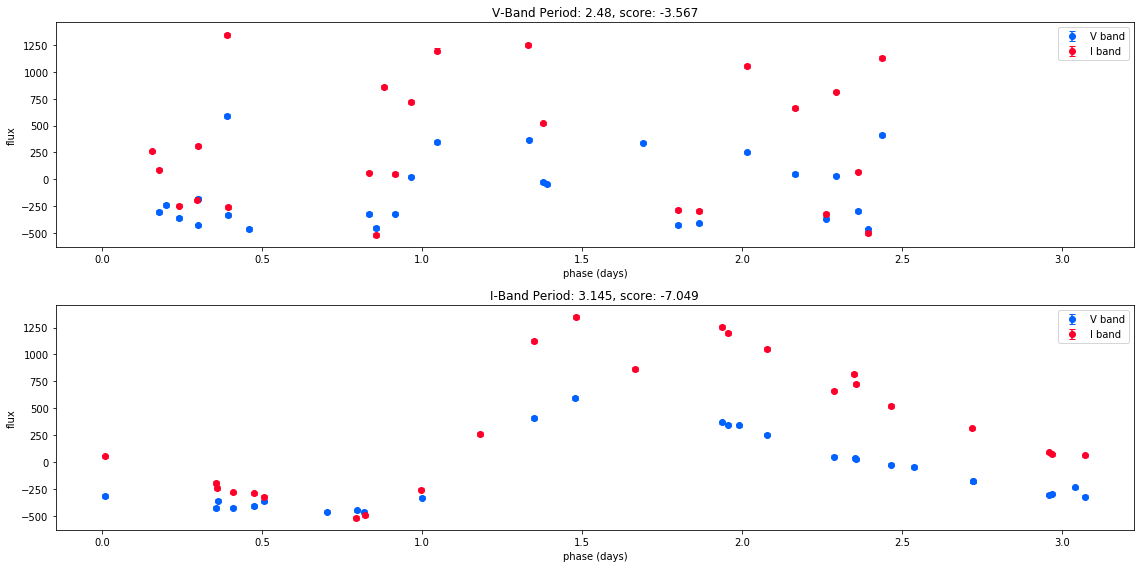

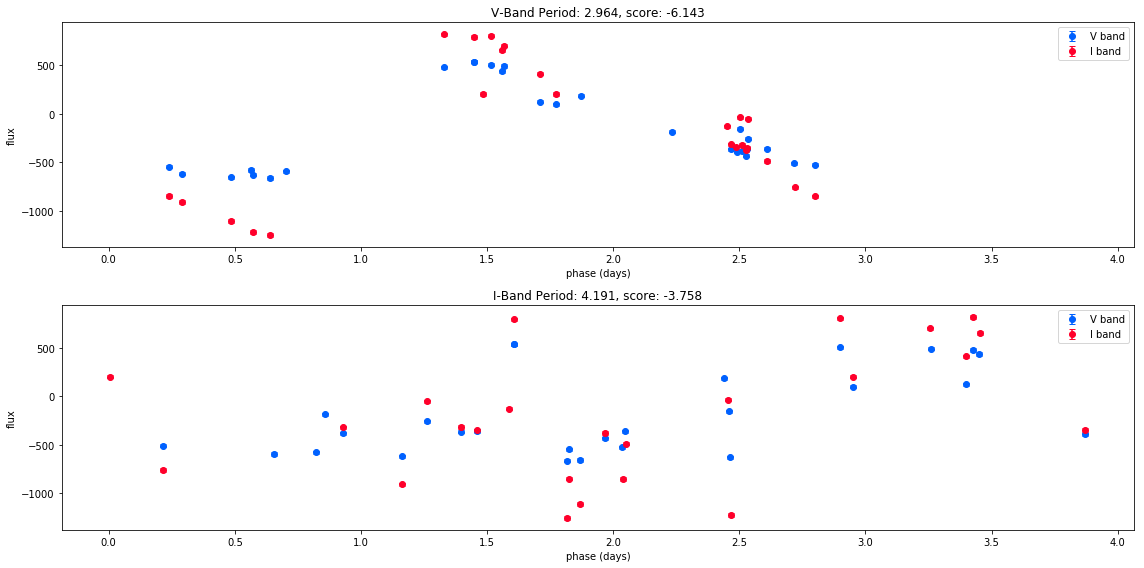

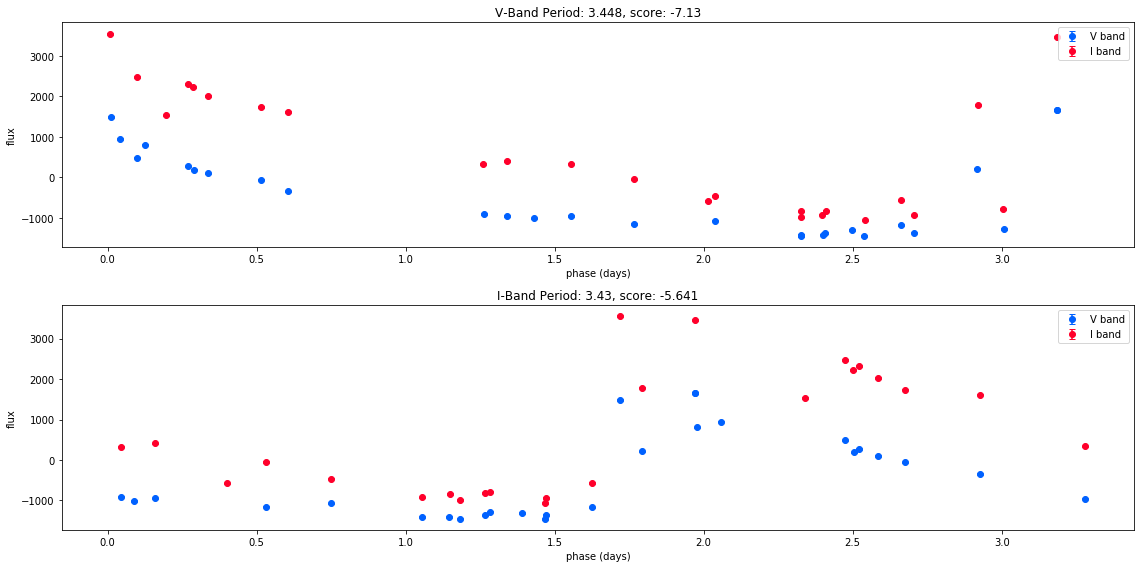

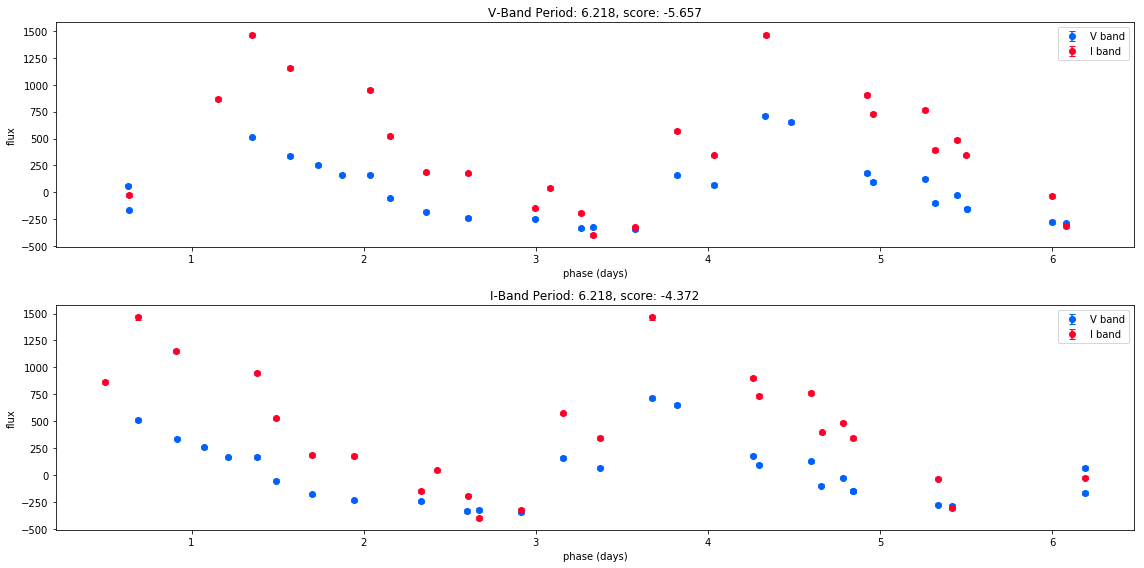

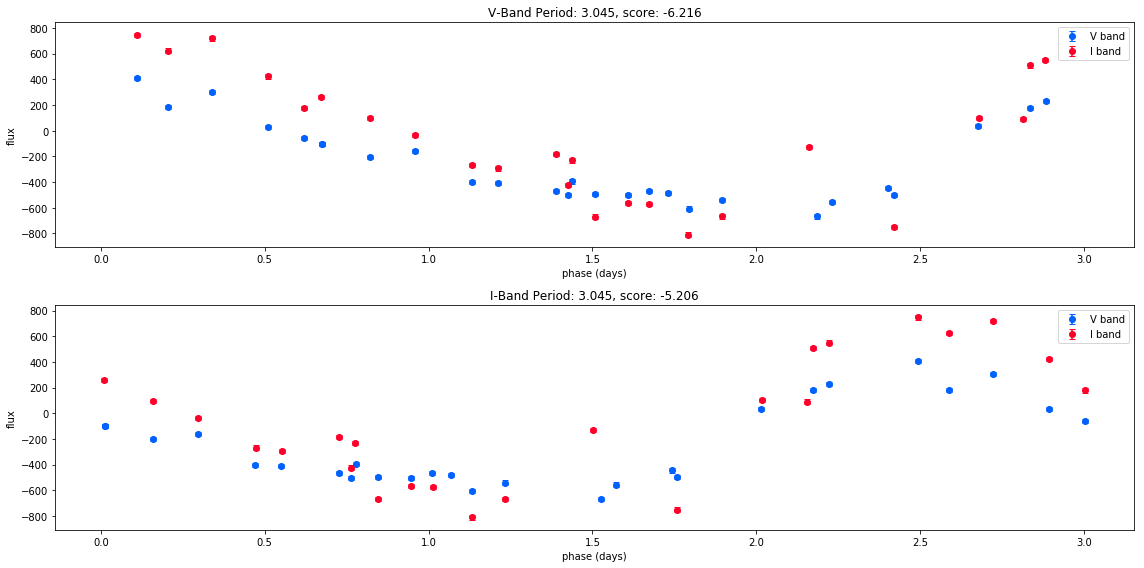

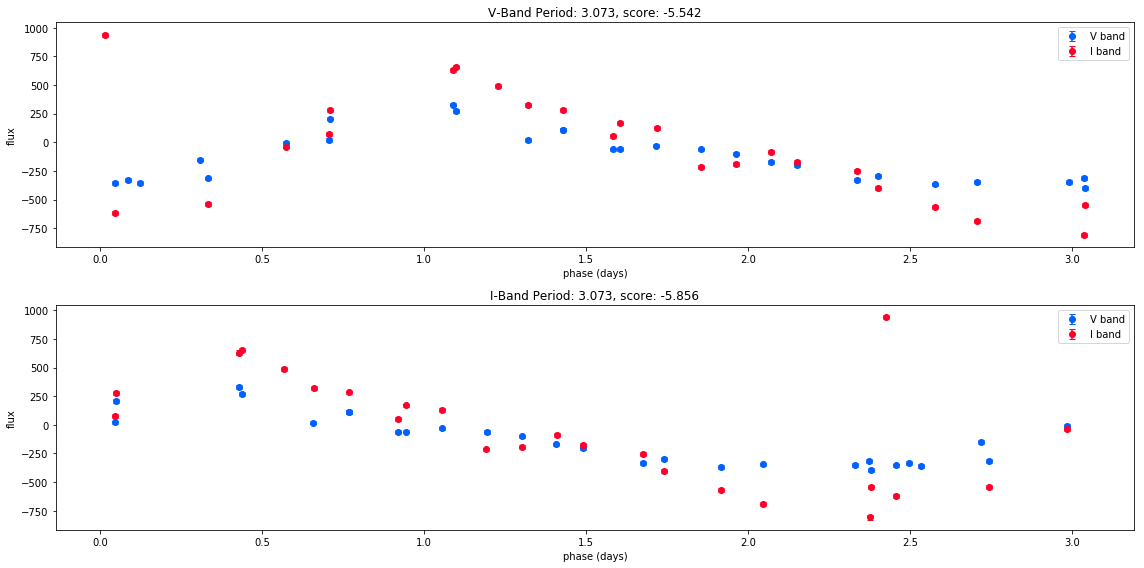

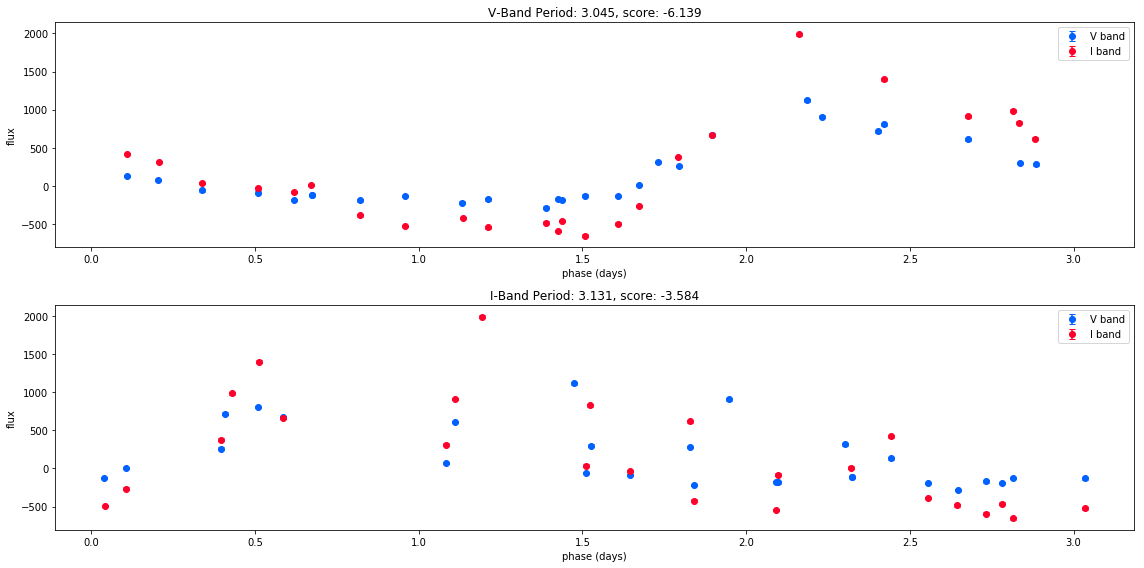

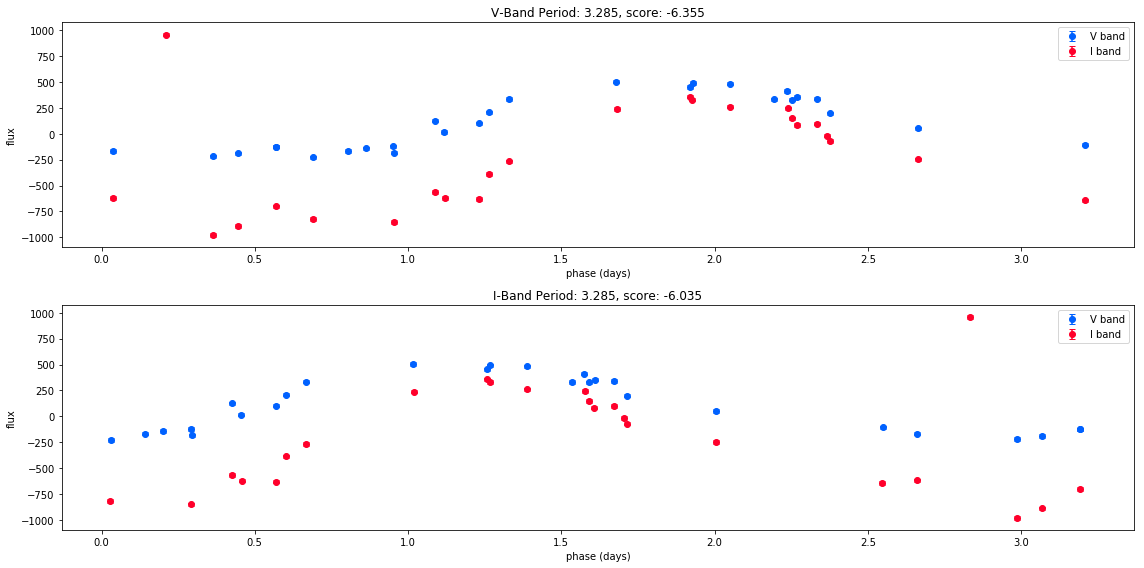

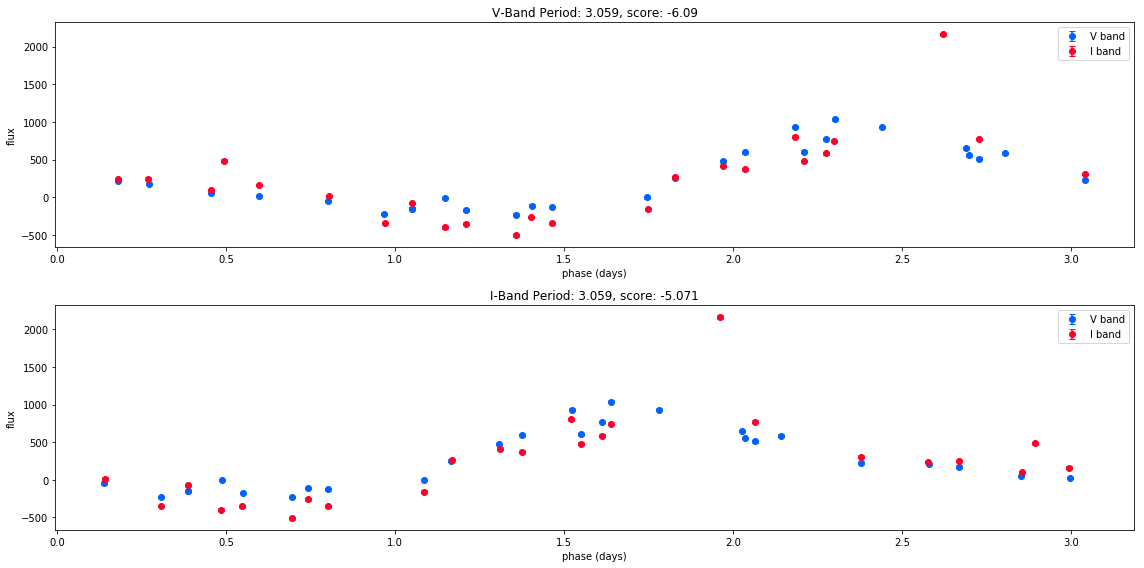

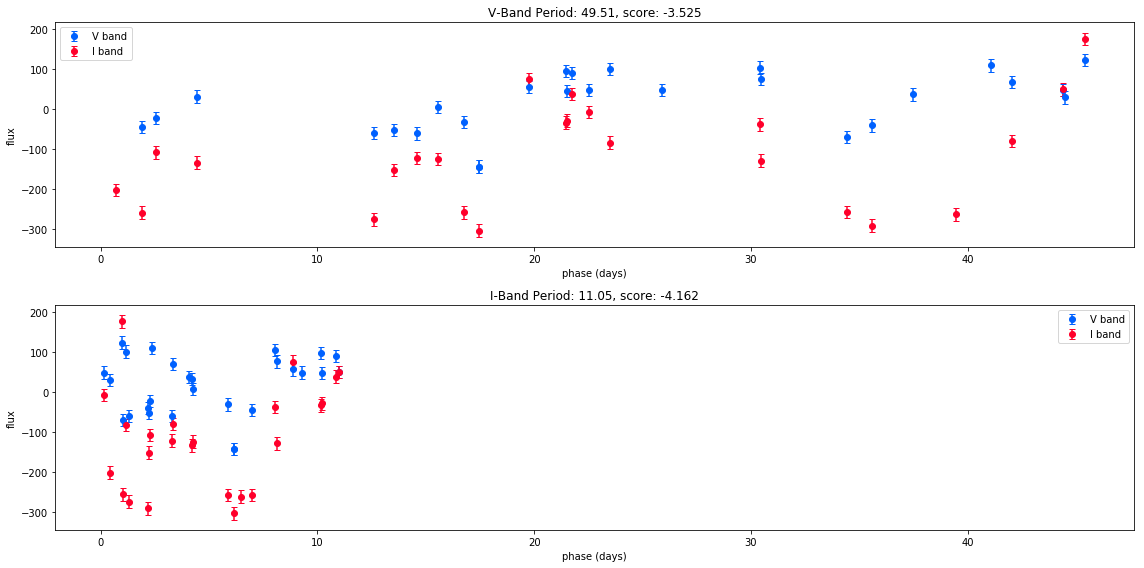

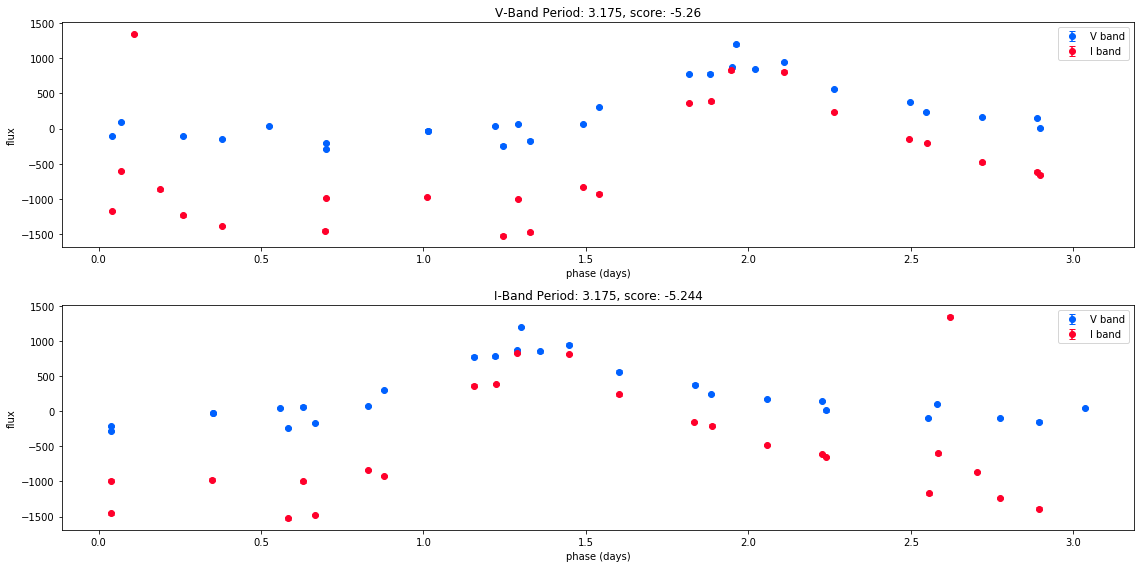

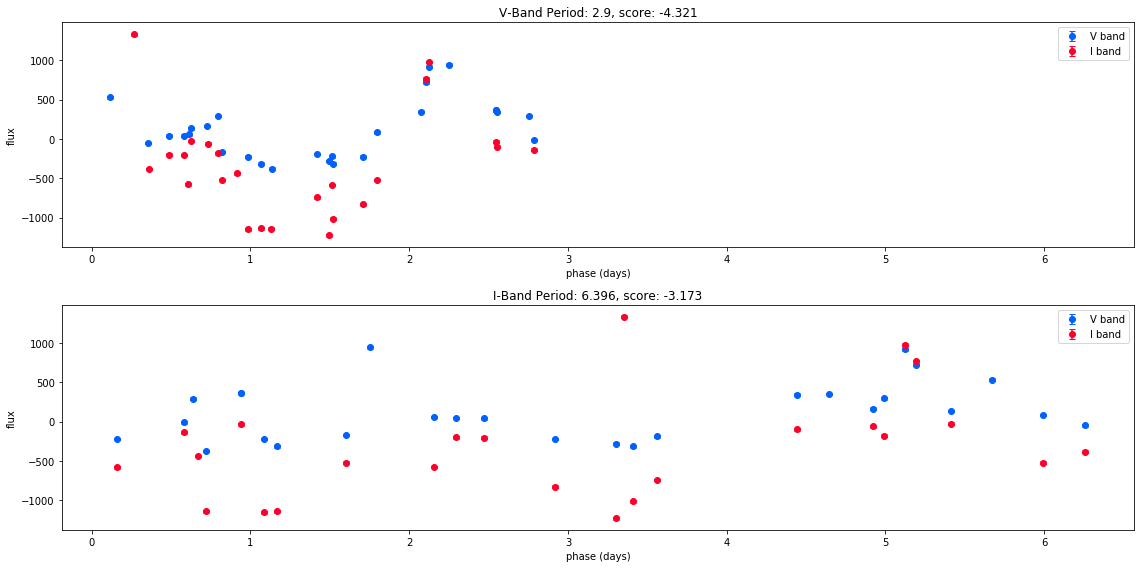

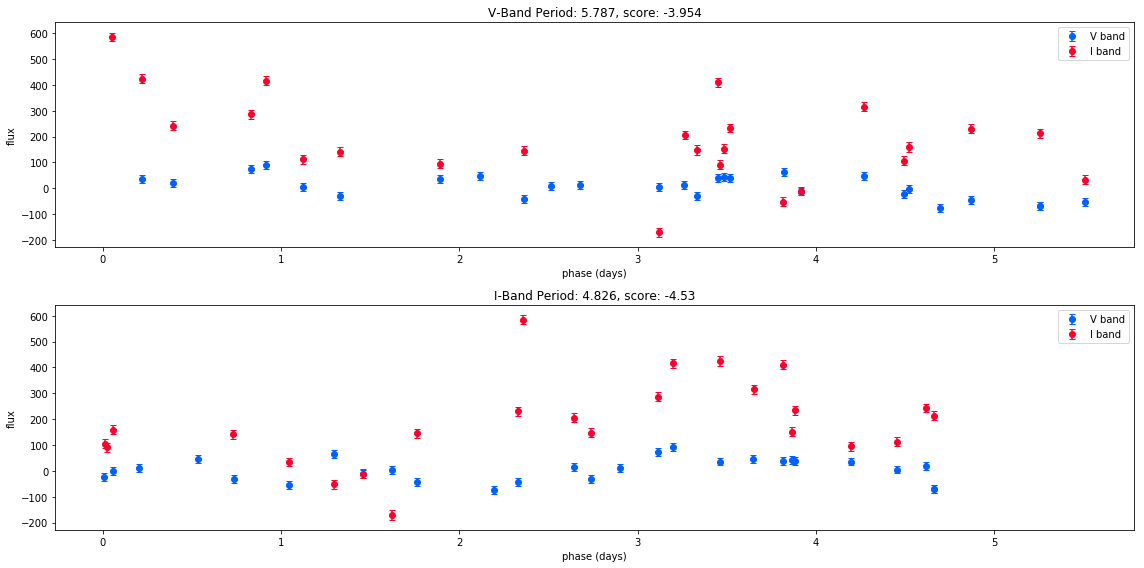

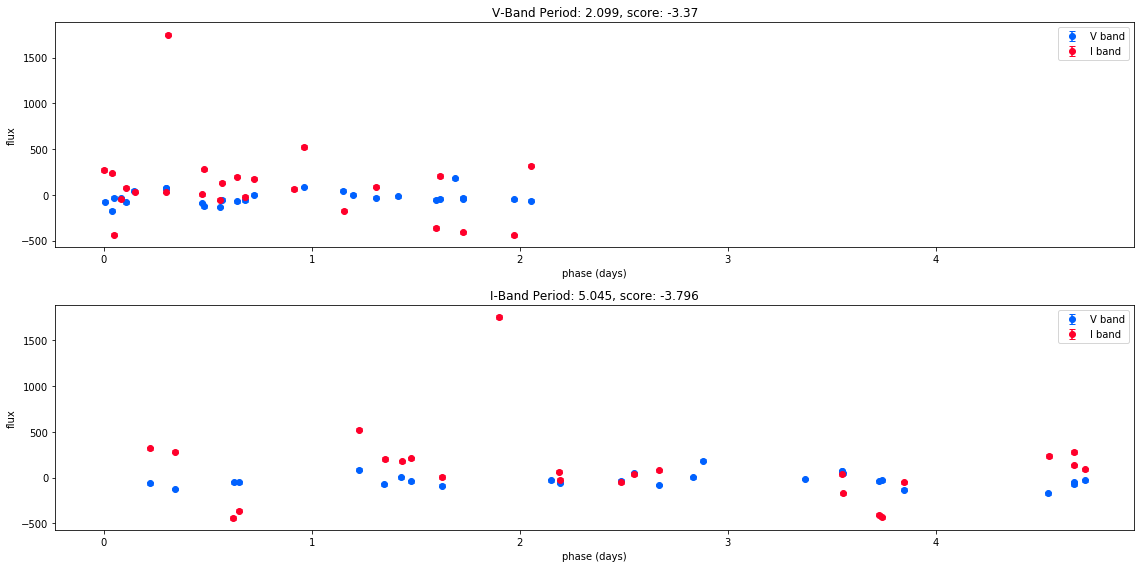

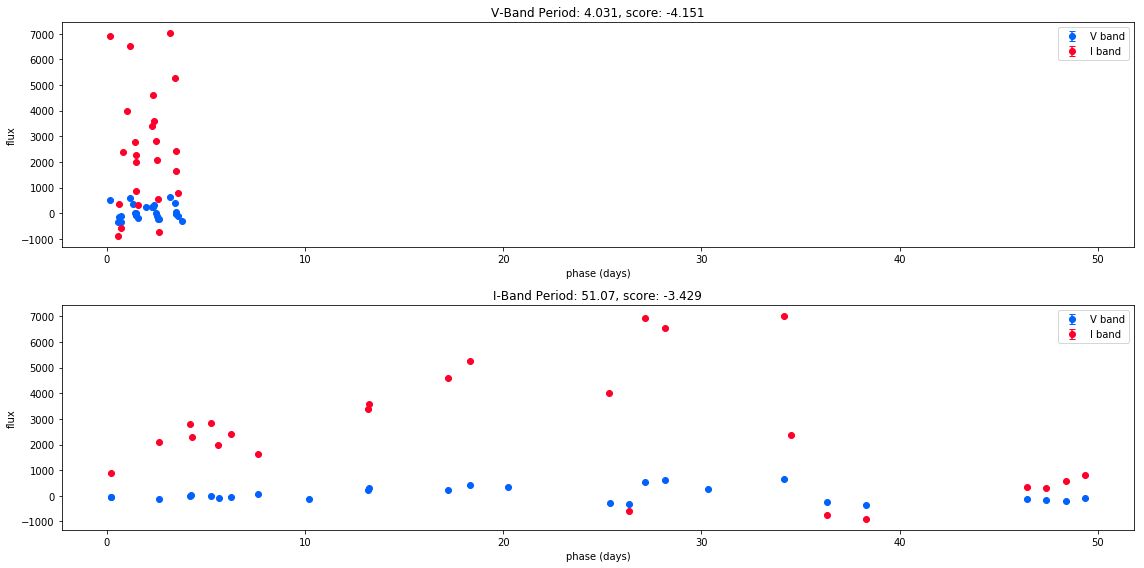

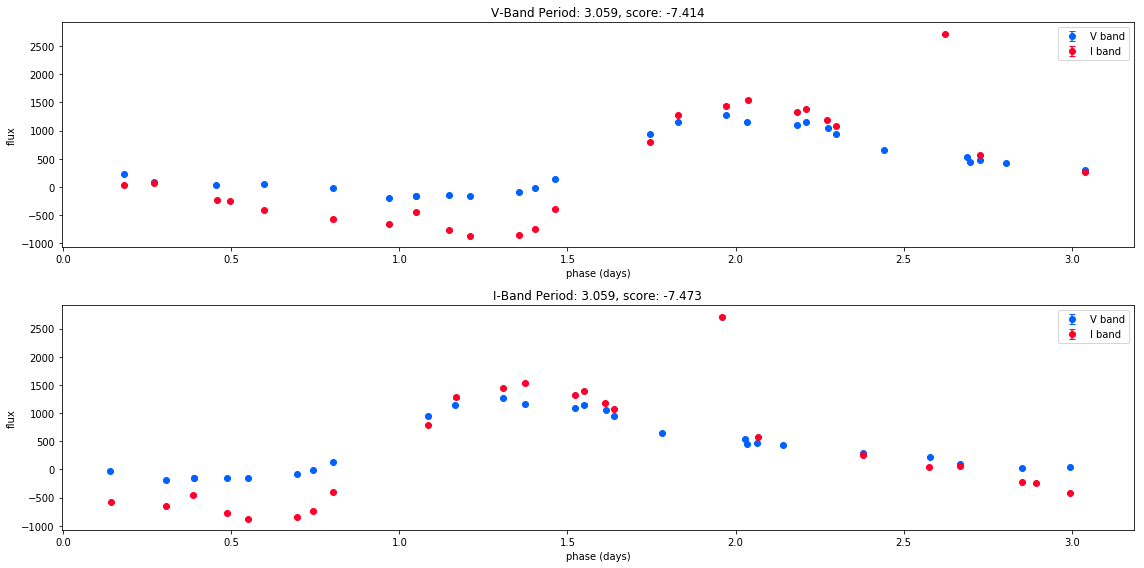

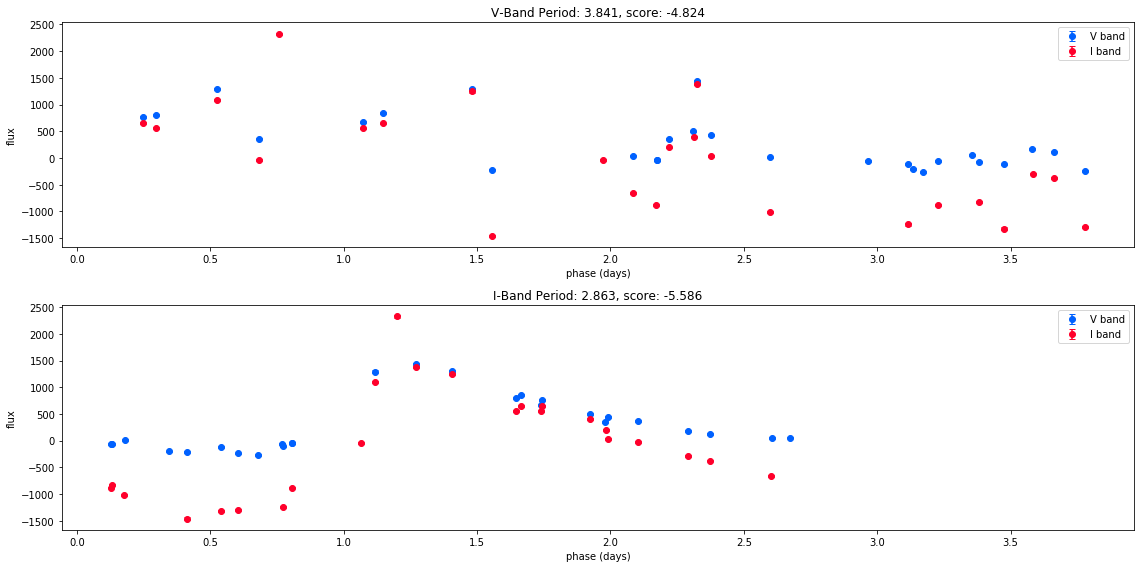

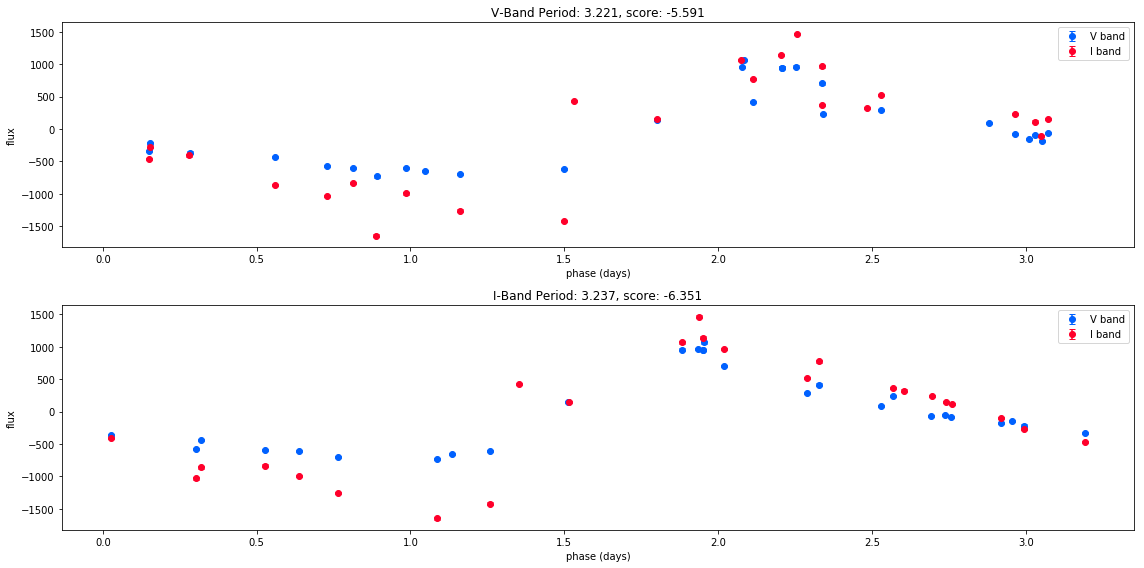

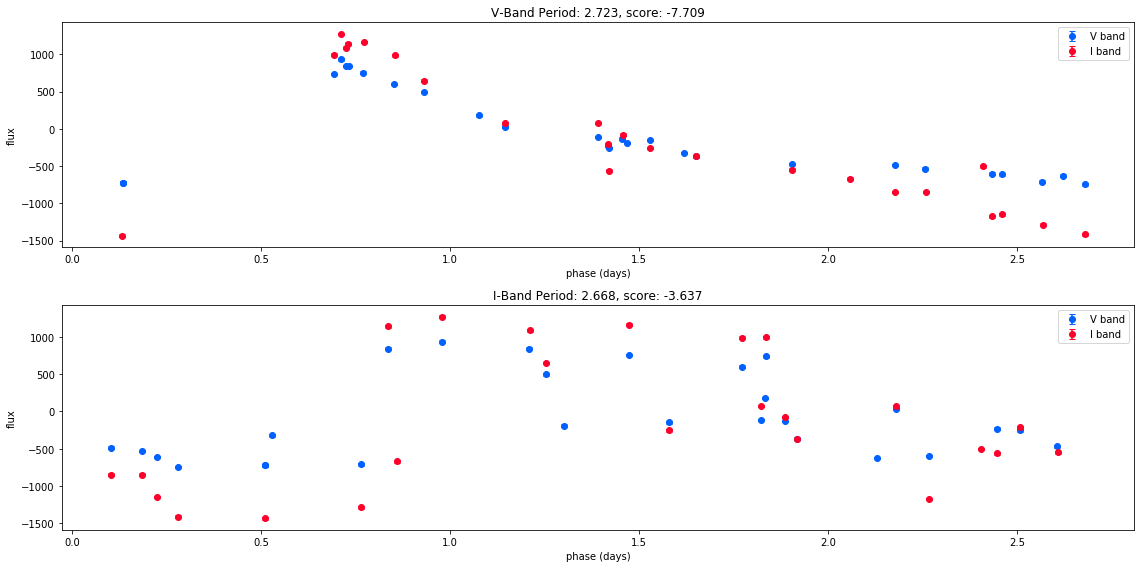

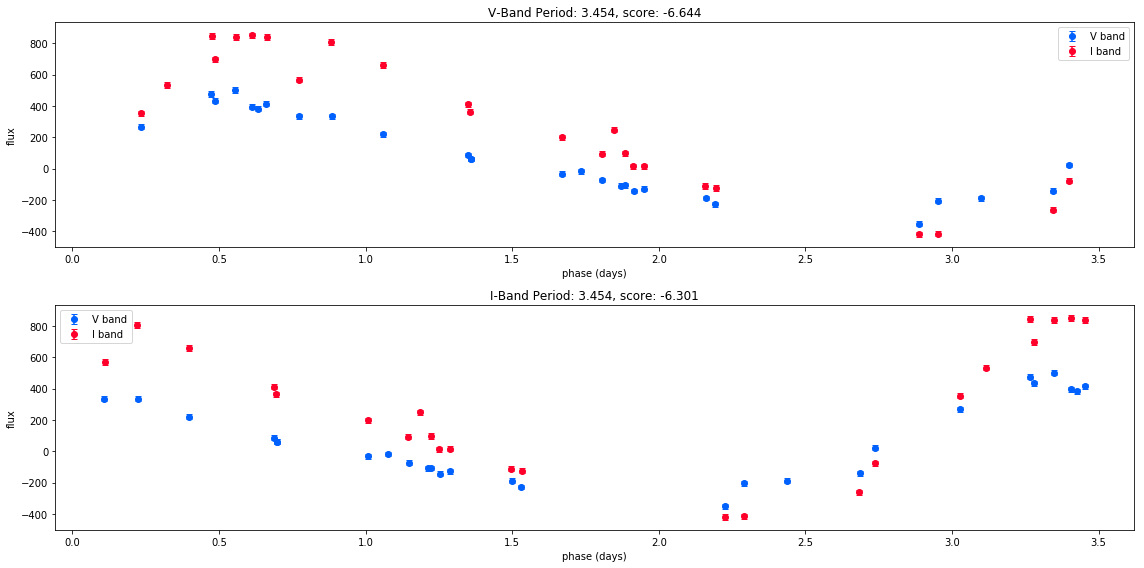

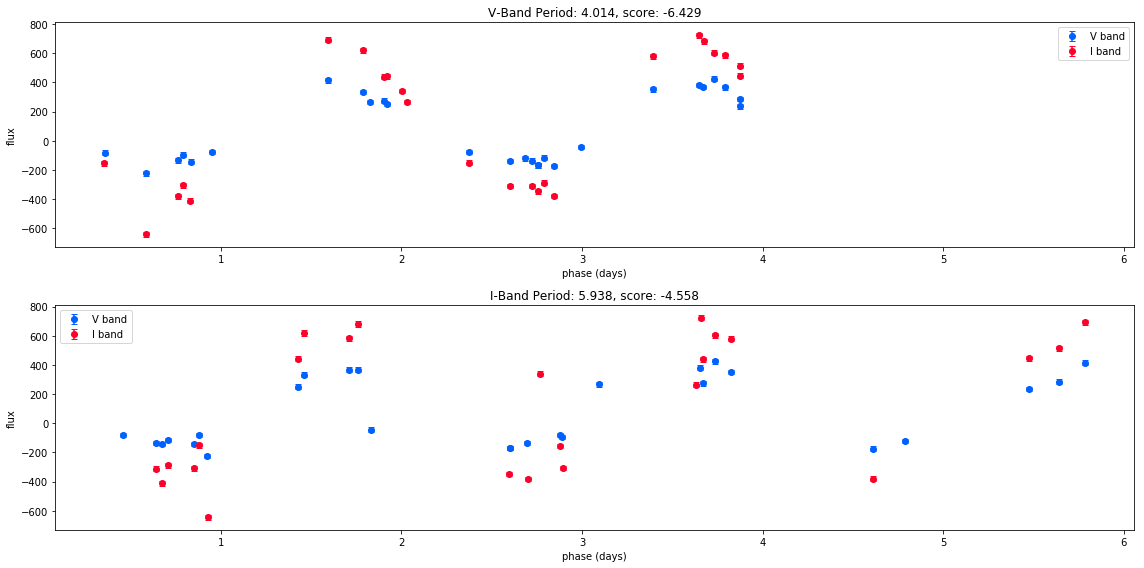

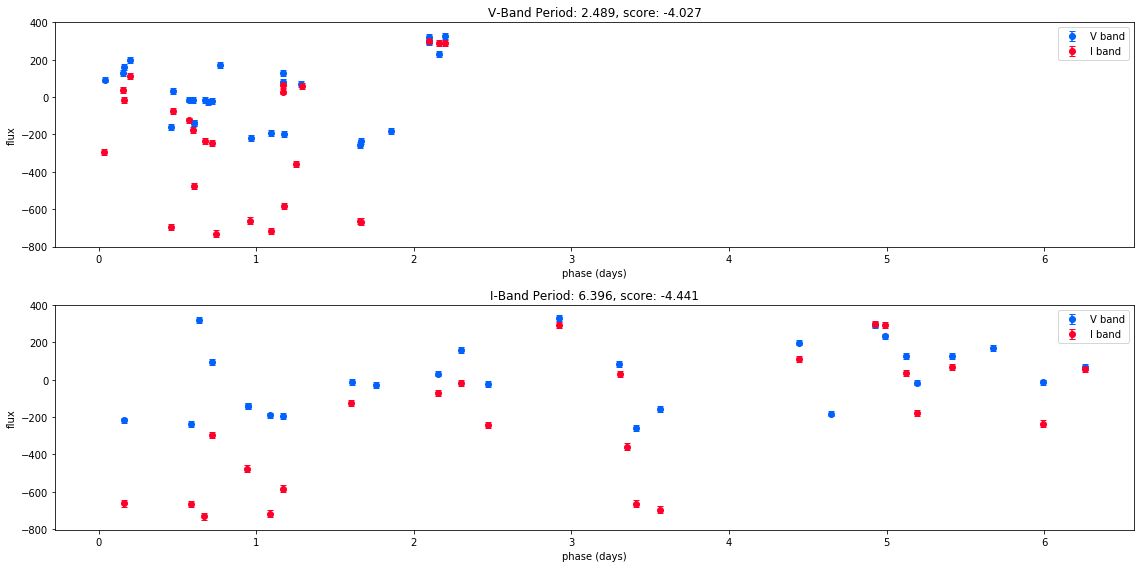

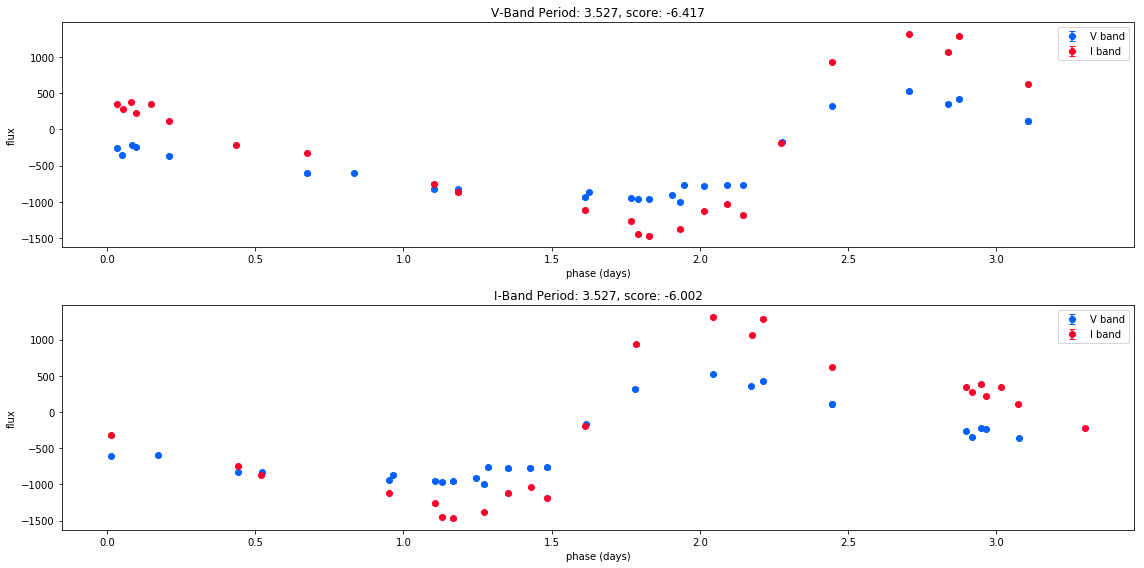

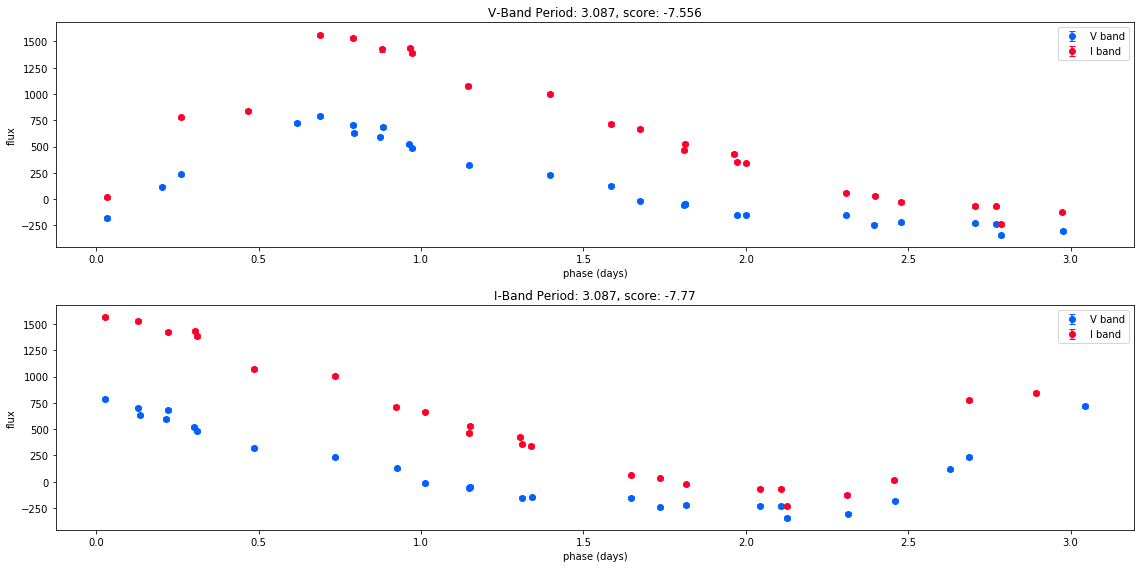

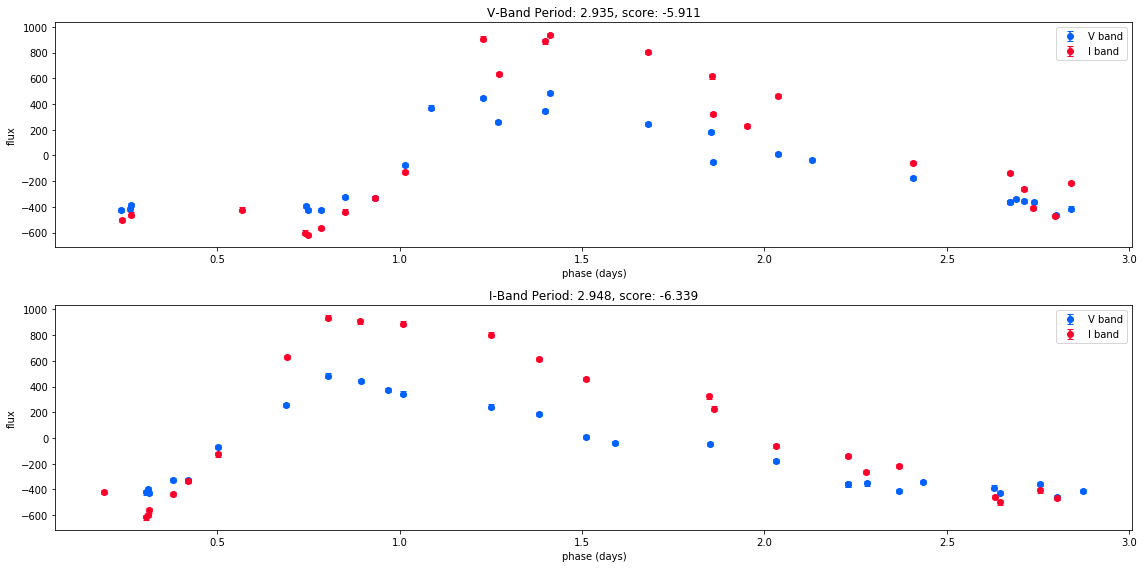

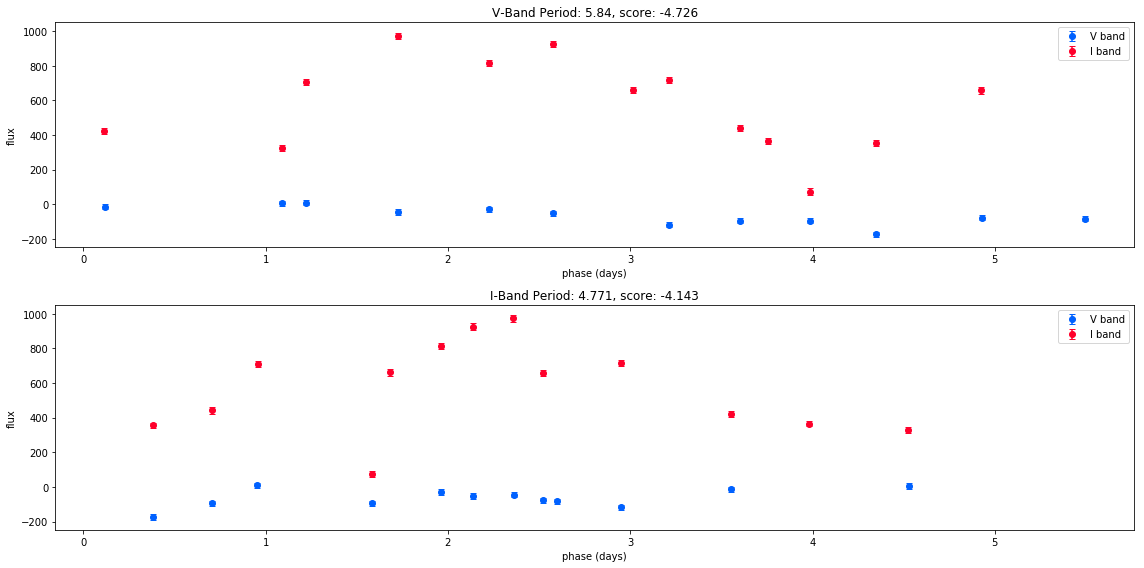

In [445]:
for star in full_crossmatch_table[mask]:
    plot_periodic(lc_table_v, lc_table_i, star, True)

In [435]:
full_crossmatch_table[mask]

<Table length=30>
     x_v           y_v       t_id ...  period_best    score_best  
                                  ...                             
   float64       float64    int64 ...    float64       float64    
------------- ------------- ----- ... ------------- --------------
1046.72827071 342.790871593   101 ... 3.03127353159 -3.72863926693
966.028998382 387.359907367   110 ... 2.04090324799 -6.03832606327
173.854427038 438.201722953   122 ... 3.20573531758  -6.3759443441
1334.77001855 523.690935759   152 ... 3.14542832435 -7.04909613312
754.110043312 730.473033436   242 ... 2.96406125816 -6.14291953672
594.731932033 828.824215402   311 ... 3.44811421565 -7.12970217626
785.901772418 849.079046386   334 ... 6.21763547642 -5.65741012799
 951.89590425 874.850898173   383 ... 3.04508343378 -6.21550953325
1036.01230111 947.033422111   515 ... 3.07311962724 -5.85552376166
          ...           ...   ... ...           ...            ...
1006.19864538 1023.25181785   716 ... 3.23682091488  -6.3514016035
848.804947418 1038.07767307   748 ... 2.72258987257 -7.70947419181
914.909585467 1061.43728772   812 ... 3.45424193135 -6.64376155764
904.329031749 1094.96566235   872 ... 4.01438927156 -6.42857457472
1010.88822082 1112.73145958   900 ... 6.39620592271 -4.44061258786
1238.20387987 1146.27879413   939 ... 3.52715468979 -6.41681962539
1155.79530654 1374.66834423  1083 ... 3.08731417517 -7.77043879406
1357.60784296 1568.52810516  1182 ...  2.9484905948  -6.3385027231
1752.55691132 1677.52745836  1226 ... 3.04511853724 -3.59085989349
11.0378581555 1854.70402594  1301 ...  5.8401995664 -4.72626609309